# Using Y-factor method to calculate active component noise

In [1]:
import os
import glob
from os.path import join as pjoin

In [2]:
from highz_exp.fit_temperature import Y_Factor_Thermometer
from highz_exp.s_params import S_Params
from highz_exp.spec_class import Spectrum
from highz_exp import plotter

pjoin = os.path.join
pbase = os.path.basename

data_path = os.path.expanduser("~/Desktop/High-Z/SA_Measurements")
output_path = pjoin(data_path, 'Processed')
plot_path = pjoin(data_path, 'Plots')

if os.path.exists(output_path) is False:
    os.makedirs(output_path)
if os.path.exists(plot_path) is False:
    os.makedirs(plot_path)

In [3]:
# define macros
# nchannels = 4
import numpy as np

nfft = 32768
fs = 3276.8/4
fbins = np.arange(0, nfft//2)
df = fs/nfft
faxis = fbins*df
faxis_hz = faxis*1e6
freq_range = (0, 500) # MHz
y_41_5 = []
y_43 = []
for i in range(len(faxis)):
    y_41_5.append(-41.5)
    y_43.append(-43)

### Calibrated Y-Factor Method for Noise Temperature Measurement of Active Components

In [ ]:
from highz_exp import load_csv
# load data for 300K-77K measurements
file_300K = pjoin(data_path, '300K.csv')
load_csv.split_csv_by_trace_name(file_300K, 
                                 header_file=pjoin(output_path, '300K_header.csv'),
                                 data_file= pjoin(output_path, '300K_data.csv'))

file_77K = pjoin(data_path, '77K.csv')
load_csv.split_csv_by_trace_name(file_77K, 
                                 header_file=pjoin(output_path, '77K_header.csv'),
                                 data_file= pjoin(output_path, '77K_data.csv'))

Split complete:
  Header file: /Users/yuntongzhou/Desktop/High-Z/SA_Measurements/Processed/300K_header.csv (30 rows)
  Data file: /Users/yuntongzhou/Desktop/High-Z/SA_Measurements/Processed/300K_data.csv (755 rows)
Split complete:
  Header file: /Users/yuntongzhou/Desktop/High-Z/SA_Measurements/Processed/77K_header.csv (30 rows)
  Data file: /Users/yuntongzhou/Desktop/High-Z/SA_Measurements/Processed/77K_data.csv (755 rows)


In [6]:
traces_77K = load_csv.parse_trace_data(pjoin(output_path, '77K_data.csv'))

WEA102_77K = Spectrum(traces_77K['Trace C']['frequency'], traces_77K['Trace C']['spectrum'], name='77K load - WEA102')
WEA101_77K = Spectrum(traces_77K['Trace A']['frequency'], traces_77K['Trace A']['spectrum'], name='77K load - WEA101 + WEA102')
LNA01_77K = Spectrum(traces_77K['Trace D']['frequency'], traces_77K['Trace D']['spectrum'], name='77K load - LNA01 + WEA101 + WEA102')

traces_300K = load_csv.parse_trace_data(pjoin(output_path, '300K_data.csv'))
WEA102_300K = Spectrum(traces_300K['Trace A']['frequency'], traces_300K['Trace A']['spectrum'], name='300K load - WEA102')
WEA101_300K = Spectrum(traces_300K['Trace B']['frequency'], traces_300K['Trace B']['spectrum'], name='300K load - WEA101 + WEA102')

Found 4 traces: ['Trace A', 'Trace B', 'Trace C', 'Trace D']
Column pairs: [(0, 1), (2, 3), (4, 5), (6, 7)]
'Trace Data' found at row 3
Trace 'Trace A': parsed 751 data points
Trace 'Trace B': parsed 751 data points
Trace 'Trace C': parsed 751 data points
Trace 'Trace D': parsed 751 data points
Successfully parsed 4 traces with data
Found 4 traces: ['Trace A', 'Trace B', 'Trace C', 'Trace D']
Column pairs: [(0, 1), (2, 3), (4, 5), (6, 7)]
'Trace Data' found at row 3
Trace 'Trace A': parsed 751 data points
Trace 'Trace B': parsed 751 data points
Trace 'Trace C': parsed 751 data points
Trace 'Trace D': parsed 0 data points
Successfully parsed 3 traces with data


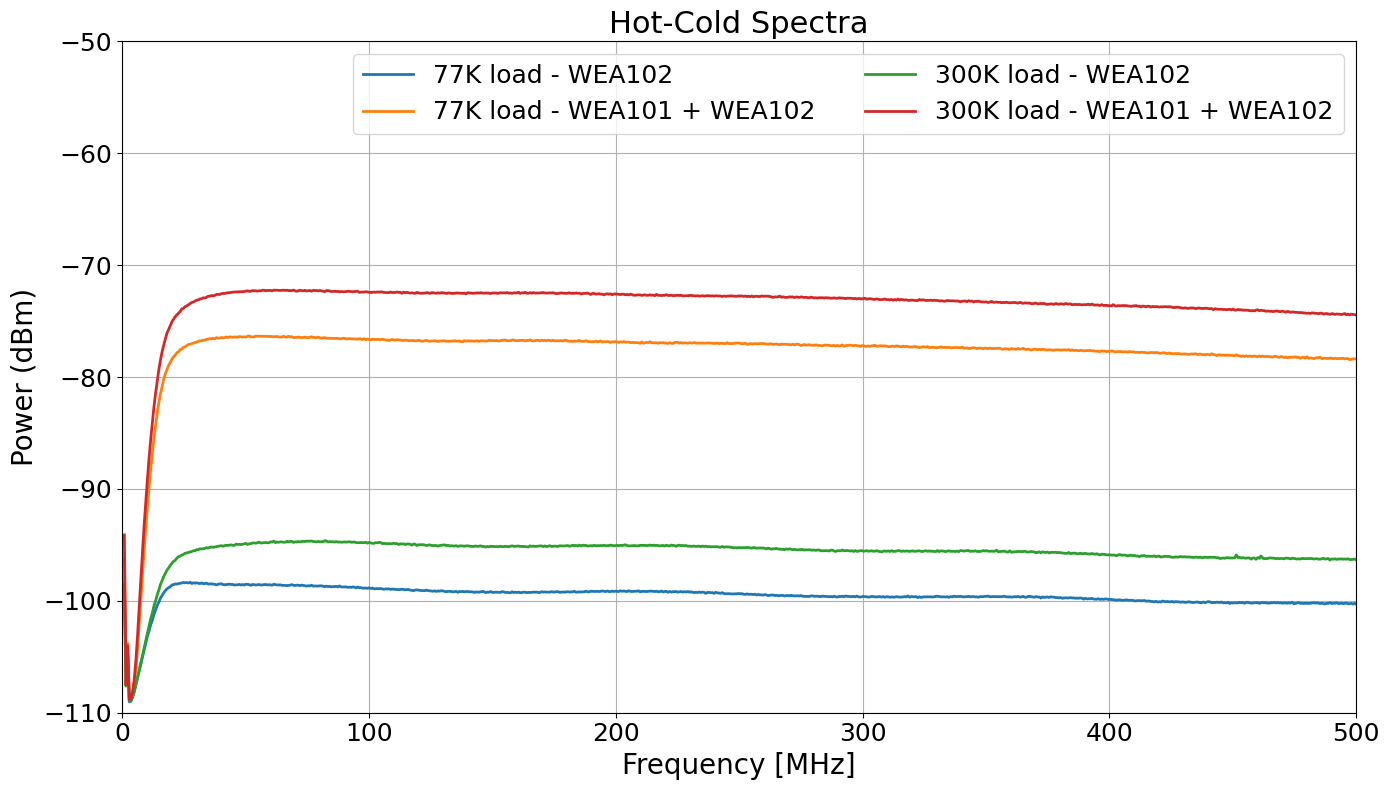

In [7]:
plotter.plot_spectrum([WEA102_77K, WEA101_77K, WEA102_300K, WEA101_300K], freq_range=freq_range, title='Hot-Cold Spectra',
                        ylabel='Power (dBm)', ymax=-50, ymin=-110, 
                        save_dir=plot_path, suffix='77K_300K')

In [8]:
cal_hot = WEA102_300K.unit_convert('dBm', 'milliwatt', 1e6).spec
cal_cold = WEA102_77K.unit_convert('dBm', 'milliwatt', 1e6).spec
hot = WEA101_300K.unit_convert('dBm', 'milliwatt', 1e6).spec
cold = WEA101_77K.unit_convert('dBm', 'milliwatt', 1e6).spec

frequency = WEA101_300K.freq/1e6  # MHz
WEA102_thermo = Y_Factor_Thermometer(frequency, cal_hot, cal_cold, 'WEA102+SA', 300, 77, RBW=300e3)
WEA101_thermo = Y_Factor_Thermometer(frequency, hot, cold, 'WEA101+WEA102', 300, 77, cal_hot=cal_hot, cal_cold=cal_cold, RBW=300e3)

/Users/yuntongzhou/Desktop/DevSpace/Highz-EXP/src/highz_exp/fit_temperature.py:78: RuntimeWarning: divide by zero encountered in divide
  T_sys = (T_hot - Y_factor * T_cold) / (Y_factor - 1)
/Users/yuntongzhou/Desktop/DevSpace/Highz-EXP/src/highz_exp/fit_temperature.py:96: RuntimeWarning: divide by zero encountered in log10
  g_dut = 10 * np.log10((DUT_hot - DUT_cold) / ((T_hot - T_cold) * k_B * RBW))
/Users/yuntongzhou/Desktop/DevSpace/Highz-EXP/src/highz_exp/fit_temperature.py:96: RuntimeWarning: invalid value encountered in log10
  g_dut = 10 * np.log10((DUT_hot - DUT_cold) / ((T_hot - T_cold) * k_B * RBW))
/Users/yuntongzhou/Desktop/DevSpace/Highz-EXP/src/highz_exp/fit_temperature.py:111: RuntimeWarning: divide by zero encountered in divide
  g_dut = 10 * np.log10((DUT_hot - DUT_cold) / (cal_hot - cal_cold))
/Users/yuntongzhou/Desktop/DevSpace/Highz-EXP/src/highz_exp/fit_temperature.py:111: RuntimeWarning: invalid value encountered in log10
  g_dut = 10 * np.log10((DUT_hot - DUT_co

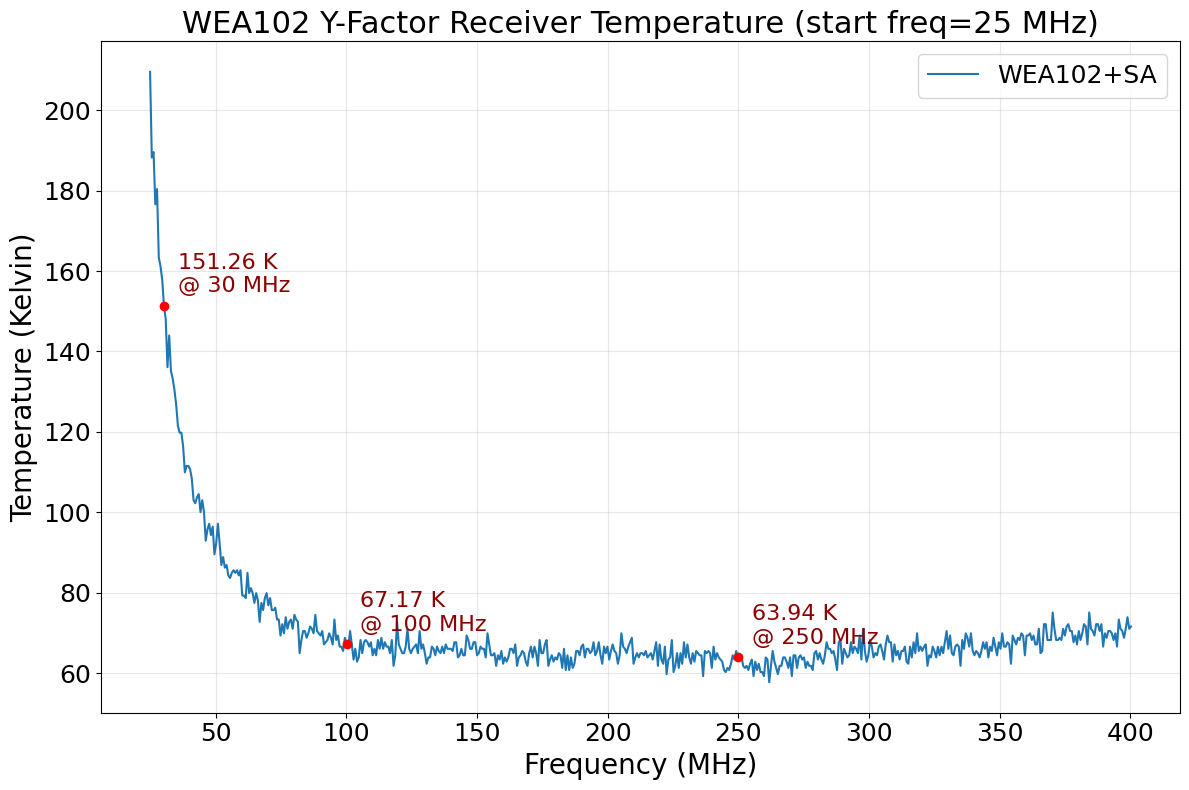

In [9]:
WEA102_thermo.plot_temps(faxis=frequency, temp_values=[WEA102_thermo.T_sys], labels=['WEA102+SA'],
                         title='WEA102 Y-Factor Receiver Temperature (start freq=25 MHz)',
                         start_freq=25,
                         save_path=pjoin(plot_path, 'WEA102_YFactor_Temps_300K_77K.png'),
                         marker_freqs=[30, 100, 250])

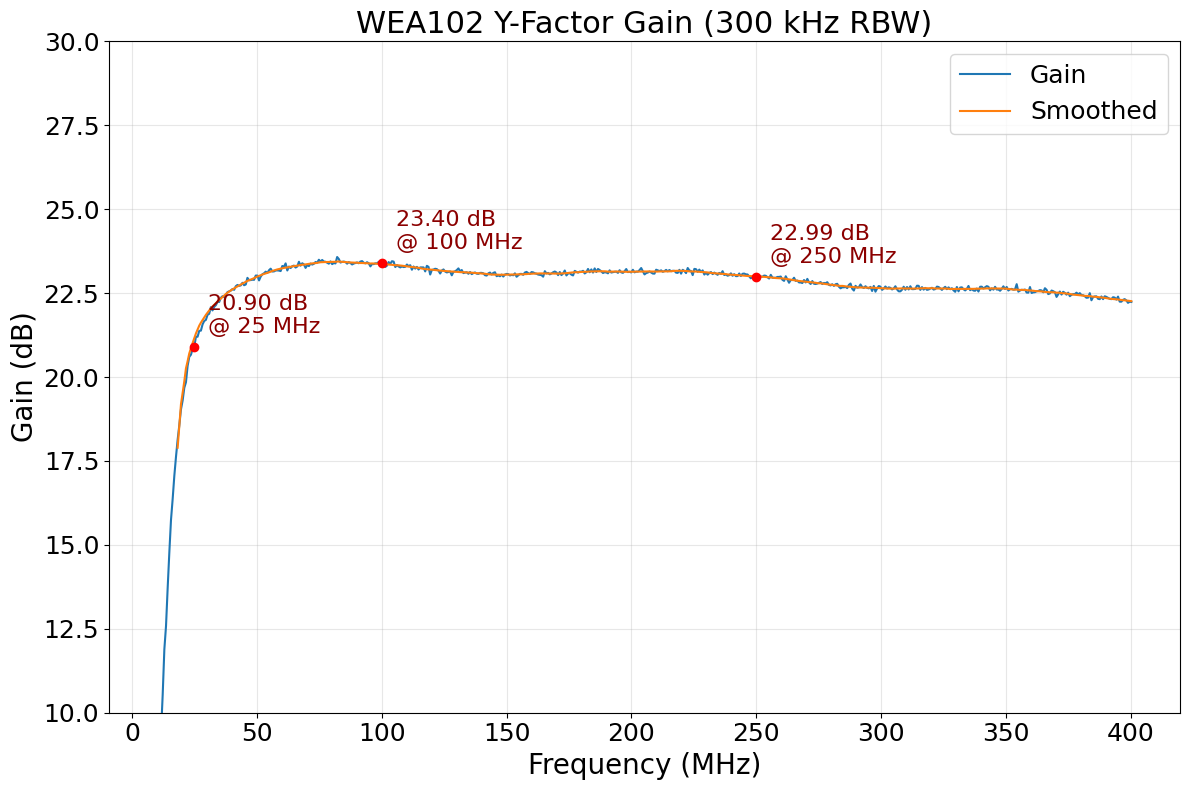

In [10]:
from highz_exp.spec_proc import smooth_spectrum
smoothed_gain = smooth_spectrum(WEA102_thermo.g, window=40)
from highz_exp import plotter
plotter.plot_gain(frequency, [WEA102_thermo.g, smoothed_gain],
                  label=['Gain', 'Smoothed'],
                title='WEA102 Y-Factor Gain (300 kHz RBW)',
                 ymax=30, ymin=10,
                 save_path=pjoin(plot_path, 'WEA102_YFactor_Gain_300kHz_RBW.png'),
                 marker_freqs=[25, 100, 250])

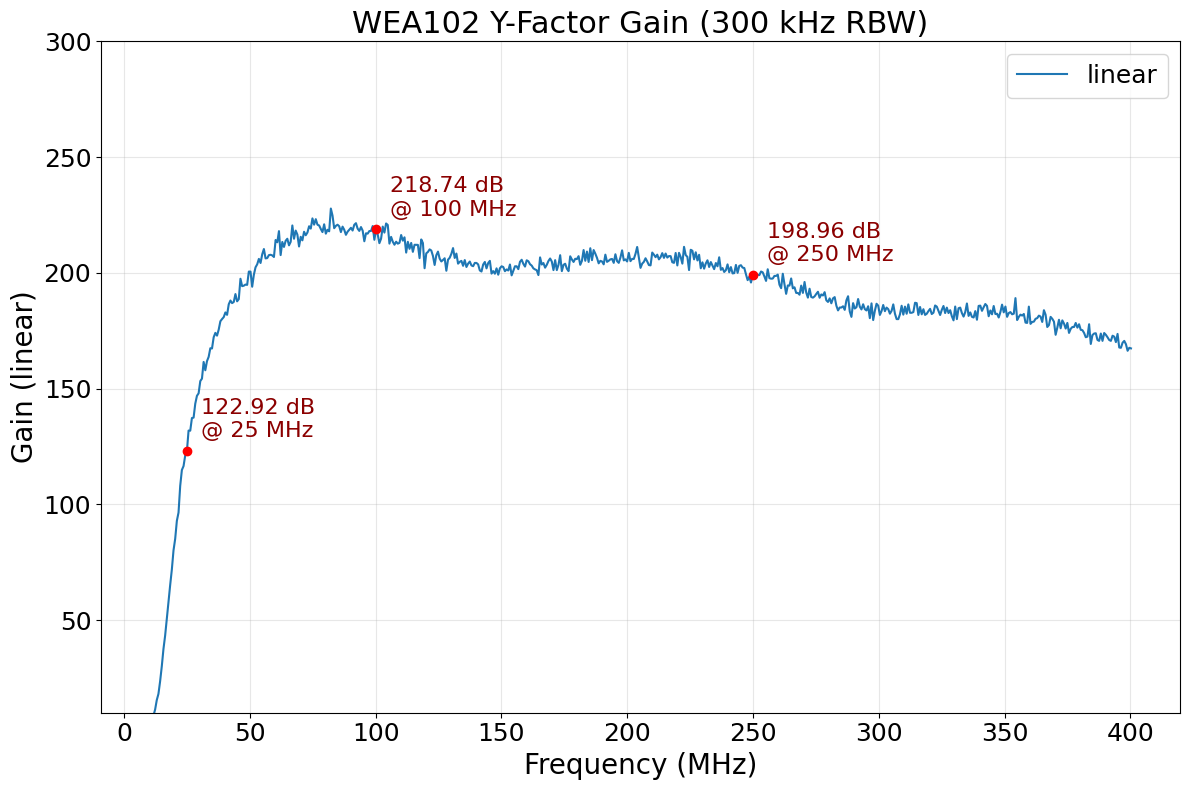

In [39]:
import matplotlib.pyplot as plt

linear_gain = 10**(WEA102_thermo.g/10)
plotter.plot_gain(frequency, [linear_gain],
                  label=['linear'],
                title='WEA102 Y-Factor Gain (300 kHz RBW)',
                 ymax=300, ymin=10,
                 ylabel='Gain (linear)',
                 save_path=pjoin(plot_path, 'WEA102_YFactor_Gain_300kHz_RBW.png'),
                 marker_freqs=[25, 100, 250])

In [ ]:
file_BB = pjoin(data_path, 'BB013.csv')
load_csv.split_csv_by_trace_name(file_BB, 
                                 header_file=pjoin(output_path, 'BB013_header.csv'),
                                 data_file= pjoin(output_path, 'BB013_data.csv')) 

traces_BB = load_csv.parse_trace_data(pjoin(output_path, 'BB013_data.csv'))

WEA102_BB = Spectrum(traces_BB['Trace A']['frequency'], traces_BB['Trace A']['spectrum'], name='BB013 load - WEA102')

Split complete:
  Header file: /Users/yuntongzhou/Desktop/High-Z/SA_Measurements/Processed/BB013_header.csv (30 rows)
  Data file: /Users/yuntongzhou/Desktop/High-Z/SA_Measurements/Processed/BB013_data.csv (755 rows)
Found 4 traces: ['Trace A', 'Trace B', 'Trace C', 'Trace D']
Column pairs: [(0, 1), (2, 3), (4, 5), (6, 7)]
'Trace Data' found at row 3
Trace 'Trace A': parsed 751 data points
Trace 'Trace B': parsed 0 data points
Trace 'Trace C': parsed 0 data points
Trace 'Trace D': parsed 0 data points
Successfully parsed 1 traces with data


In [34]:
WEA102_BB.unit_convert('dBm', 'kelvin', channel_width=300e3, inplace=True)

<Spectrum name='BB013 load - WEA102' points=751 metadata_keys=['unit']>

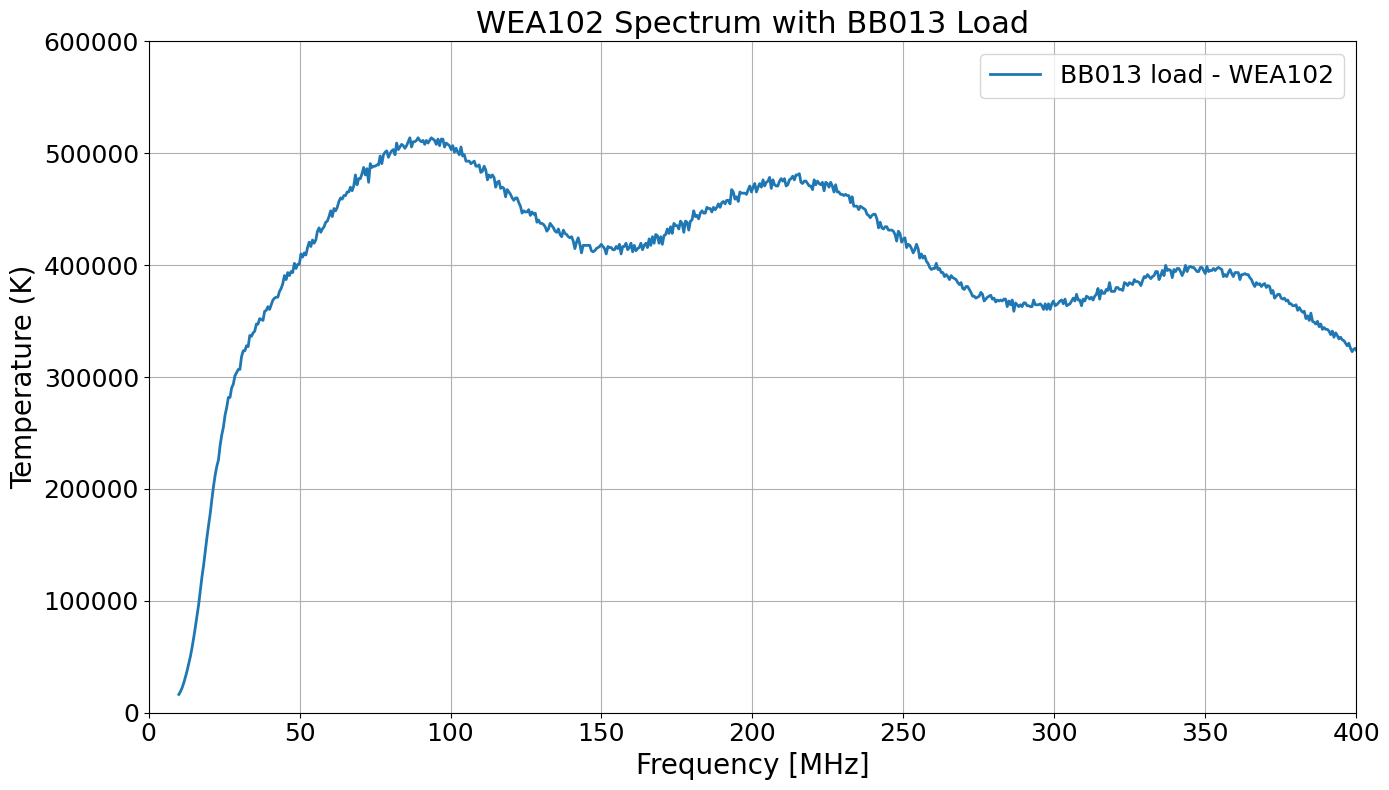

In [37]:
plotter.plot_spectrum([WEA102_BB], freq_range=(0,400), title='WEA102 Spectrum with BB013 Load',
                        ylabel='Temperature (K)', ymax=6e5, ymin=0,
                        save_dir=plot_path, suffix='kelvin')

/Users/yuntongzhou/Desktop/DevSpace/Highz-EXP/src/highz_exp/fit_temperature.py:236: RuntimeWarning: invalid value encountered in multiply
  noise_values = self.T_sys * g_values


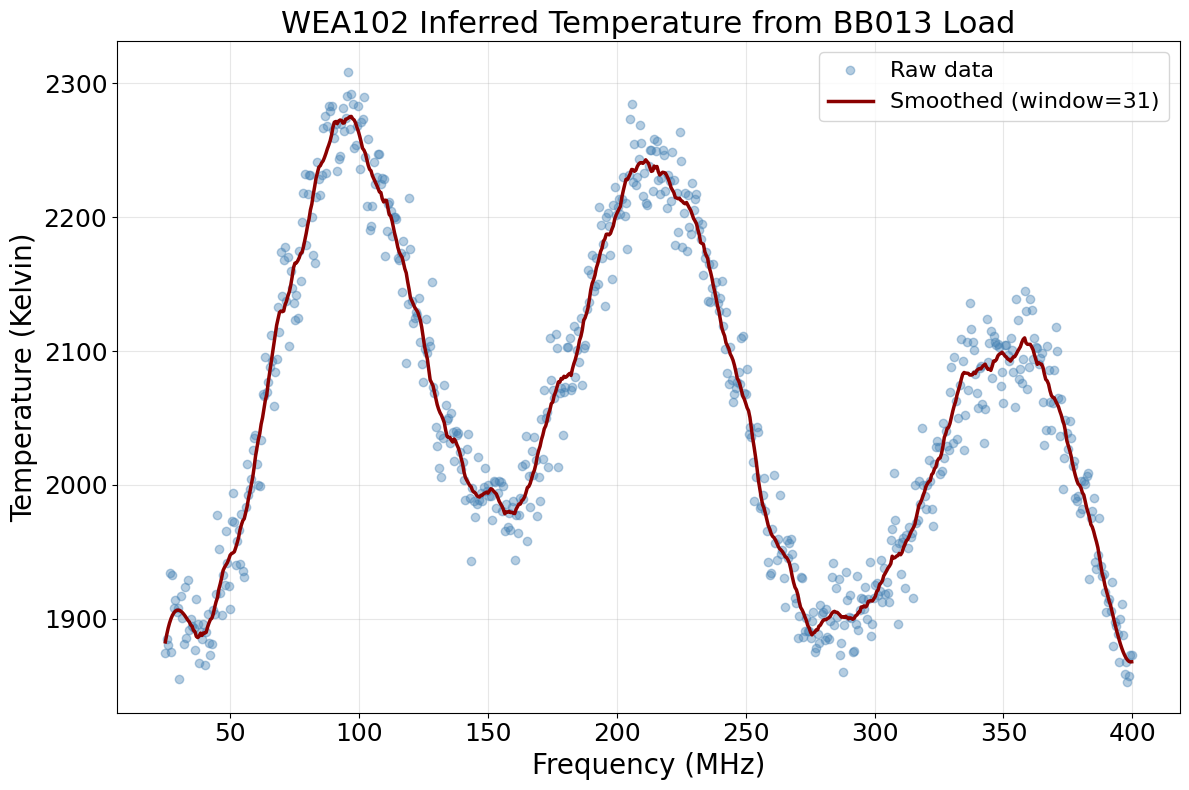

array([1882.66011944, 1888.21975506, 1892.92655973, 1896.83319774,
       1899.99233342, 1902.45663106, 1904.27875499, 1905.5113695 ,
       1906.20713892, 1906.41872755, 1906.19879971, 1905.6000197 ,
       1904.67505183, 1903.47656042, 1902.05720978, 1900.46966422,
       1898.85800788, 1897.64019345, 1895.26198621, 1894.44874755,
       1891.23182091, 1890.41977122, 1886.76620946, 1885.88042382,
       1886.90194707, 1889.22547003, 1887.5022867 , 1889.35543488,
       1889.2095693 , 1889.86896243, 1893.81589091, 1896.88070533,
       1899.40181923, 1900.28474401, 1903.47417846, 1908.4069436 ,
       1912.59955504, 1915.74698229, 1922.16806851, 1926.20517035,
       1930.74209105, 1936.04209414, 1938.37242497, 1940.14516478,
       1941.81773566, 1944.40439402, 1947.47608985, 1948.70487005,
       1949.19014681, 1950.03705521, 1953.19648661, 1956.7630698 ,
       1960.7538455 , 1966.33605479, 1970.15367346, 1973.31086301,
       1974.70550067, 1979.29308171, 1983.52192541, 1989.76174

In [ ]:
WEA102_thermo.infer_temperature(WEA102_BB, start_freq=25, end_freq=400,
                                smoothing='savgol', window_size=31,
                                
                                title='WEA102 Inferred Temperature from BB013 Load',
                                save_path=pjoin(plot_path, 'WEA102_Inferred_Temperature_BB013.png'))